## 0. Prepare Environment
### Import relevant packages

In [39]:
from GPR import GaussianProcessRegressionLengthscale
import numpy as np # Numpy is a popular numeric computation package
import pandas as pd # Pandas is a friendly data wrangling package/library
from scipy import linalg
import matplotlib as pl
# Setting a specific random seed, to get reproducibility across students.
# @Students, you can remove or change to your own seed to try with your own training subsets.
np.random.seed(100) 

## 1. Gaussian Process Regression

###  Load Data

Data obtained from NOAA ESRL: "NOAA Earth System Research Laboratories (ESRL) pursue a broad and comprehensive understanding of the many physical, chemical and biological processes that comprise the Earth..."

https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_gl.csv

     year  month   decimal  average  average_unc   trend  trend_unc
0    1979      1  1979.042   336.56         0.10  335.92       0.09
1    1979      2  1979.125   337.29         0.09  336.25       0.09
2    1979      3  1979.208   337.88         0.10  336.51       0.09
3    1979      4  1979.292   338.32         0.11  336.72       0.09
4    1979      5  1979.375   338.26         0.04  336.71       0.10
..    ...    ...       ...      ...          ...     ...        ...
524  2022      9  2022.708   414.60         0.10  417.45       0.06
525  2022     10  2022.792   416.12         0.10  417.68       0.06
526  2022     11  2022.875   417.73         0.10  417.94       0.06
527  2022     12  2022.958   418.77         0.10  418.16       0.06
528  2023      1  2023.042   419.31         0.10  418.24       0.06

[529 rows x 7 columns]


<AxesSubplot:xlabel='decimal'>

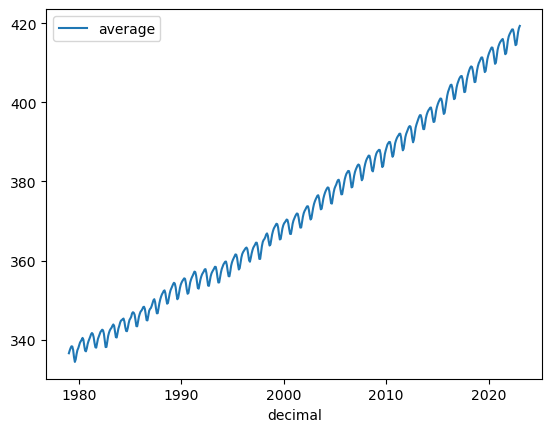

In [40]:
# Actual line to load dataset
# Very important to use comment='#', since the csv file contains introductory comments that need to be ignored
df_co2 = pd.read_csv('https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_gl.csv', comment='#')

print(df_co2)

#Plot the data
df_co2.plot('decimal','average')

The column *decimal* was calculated by NOAA in order to match date as a decimal number corresponding to the day at the middle of each month:

\begin{equation}
\text{decimal} = \text{year}+\frac{\text{month}-0.5}{12}
\end{equation}

### Preprocess Data

#### Filter Data

The following block of code filters the useful columns (*decimal, average*) and keeps only the observations with dates we are interested in.

In [41]:
df_co2 = df_co2[['decimal','average']] # Keep only the columns decimal and average

df_co2_filtered = df_co2[(df_co2['decimal'] >= 2016) & (df_co2['decimal'] < 2019)]

print(df_co2_filtered)

      decimal  average
444  2016.042   402.64
445  2016.125   403.27
446  2016.208   403.86
447  2016.292   404.39
448  2016.375   404.45
449  2016.458   403.66
450  2016.542   402.11
451  2016.625   400.80
452  2016.708   400.99
453  2016.792   402.42
454  2016.875   403.78
455  2016.958   404.69
456  2017.042   405.32
457  2017.125   405.91
458  2017.208   406.32
459  2017.292   406.61
460  2017.375   406.65
461  2017.458   405.86
462  2017.542   404.11
463  2017.625   402.57
464  2017.708   402.66
465  2017.792   404.16
466  2017.875   405.70
467  2017.958   406.75
468  2018.042   407.56
469  2018.125   408.24
470  2018.208   408.77
471  2018.292   409.08
472  2018.375   408.94
473  2018.458   408.06
474  2018.542   406.47
475  2018.625   405.10
476  2018.708   405.17
477  2018.792   406.65
478  2018.875   408.13
479  2018.958   409.18


#### Transform (extract) data from Pandas dataframe to Numpy array

In [42]:
x = df_co2_filtered['decimal'].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = df_co2_filtered['average'].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit

print(f"x has shape ({x.shape[0]},{x.shape[1]}) and has range [{np.min(x):.3f},{np.max(x):.3f}]")
print(f"y has shape ({y.shape[0]},{y.shape[1]}) and has range [{np.min(y):.3f},{np.max(y):.3f}]")

x has shape (36,1) and has range [2016.042,2018.958]
y has shape (36,1) and has range [400.800,409.180]


#### Plot data

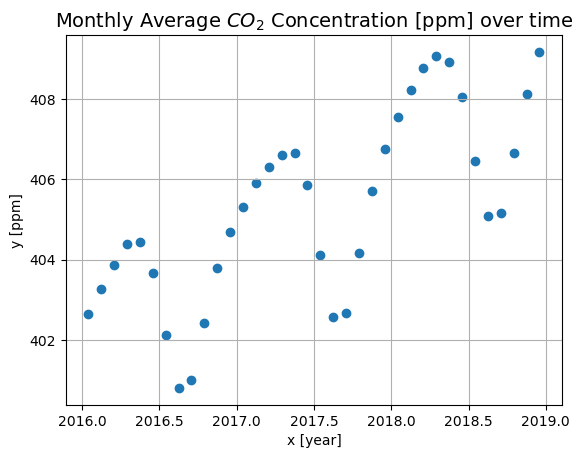

In [43]:
import matplotlib.pylab as pl
%matplotlib inline

#scatter plot of y vs. x
pl.scatter(x, y) # Interpolation data
pl.title('Monthly Average $CO_2$ Concentration [ppm] over time', fontsize=14)
pl.xlabel('x [year]')
pl.ylabel('y [ppm]')
pl.grid()

#### Normalisation

Let us normalise the training data between 0,1.

In [44]:
def normalise1D(z, new_min=0, new_max=1): 
    z_min = np.min(z)
    z_max = np.max(z)
    z_normalised = new_min + (z - z_min)*(new_max - new_min)/(z_max - z_min) 
    return z_normalised

x_norm = normalise1D(x) # create a new variable to avoid loosing track of variables
y_norm = normalise1D(y)

y_norm = y_norm - np.mean(y_norm)

#### Split training (70%) and for interpolation test (30%) set 

Training set contains 25 observations.
Training set contains 11 observations.


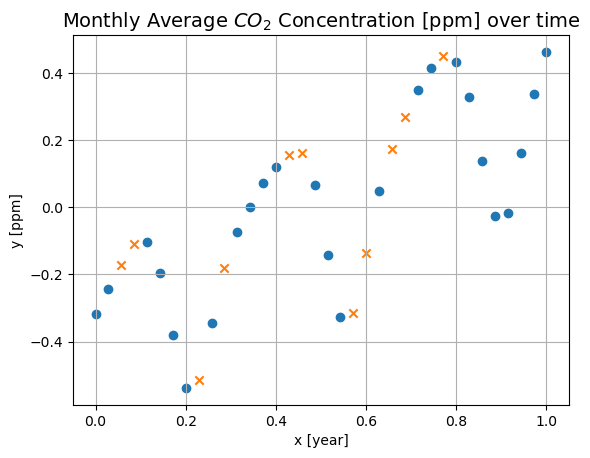

In [45]:
random_indices = np.random.permutation(x.shape[0])
train_ratio = .7
n_train = int(np.floor(x_norm.shape[0]*train_ratio))
n_test = x_norm.shape[0]-n_train
train_idx, test_idx = random_indices[:n_train], random_indices[n_train:]
x_norm_train, x_norm_test = x_norm[train_idx,:], x_norm[test_idx,:]
y_norm_train, y_norm_test = y_norm[train_idx,:], y_norm[test_idx,:]

print(f"Training set contains {y_norm_train.shape[0]} observations.")
print(f"Training set contains {y_norm_test.shape[0]} observations.")

pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.title('Monthly Average $CO_2$ Concentration [ppm] over time', fontsize=14)
pl.xlabel('x [year]')
pl.ylabel('y [ppm]')
pl.grid()

#### GP Regression Implementation



Following Bishop, C. M. Pattern Recognition and Machine Learning. Oxidation Communications Vol. 27 (Springer, 2004).

I need to calculate the posterior predictive distribution:

\begin{equation}
p(\mathbf{f}_* | \mathbf{X},\mathbf{y}, \mathbf{x}_*) = \mathcal{N}(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*))
\end{equation}

\begin{equation}
\bar{\mathbf{f}}_* = K(\mathbf{x}_*,\mathbf{X})\left[ K(\mathbf{X},\mathbf{X}) + \sigma_n^2 I \right]^{-1}\mathbf{y}
\end{equation}

\begin{equation}
\text{cov}(\mathbf{f}_*) = K(\mathbf{x}_*,\mathbf{x}_*) - K(\mathbf{x}_*,\mathbf{X})\left[ K(\mathbf{X},\mathbf{X}) + \sigma_n^2 I \right]^{-1}K(\mathbf{X},\mathbf{x}_*)
\end{equation}


This class incorporates the calculation of the log marginal likelihood – in order to find the best hyperparameters to fit the data:

\begin{equation}
p(\mathbf{y}|\mathbf{X}) = \int{p(\mathbf{y}|\mathbf{f},\mathbf{X})p(\mathbf{f}|X)}\text{d}\mathbf{f}
\end{equation}

\begin{equation}
\text{log}p(\mathbf{y}|\mathbf{X}) = -\frac{1}{2}\mathbf{y}^T\left(K+\sigma_n^2I\right)^{-1}\mathbf{y} - \frac{1}{2}\text{log}|K+\sigma_n^2I|-\frac{N}{2}\text{log}2\pi
\end{equation}


In [64]:
x_star = np.linspace(-0.02,1.02,100)[:,np.newaxis] 
signal_variance = 1 #1
lengthscale = 0.3#0.3
sigma_n = 0.05#0.1
gp = GaussianProcessRegressionLengthscale("Squared Exponential", x_norm_train, y_norm_train, [signal_variance,lengthscale], sigma_n)


Log Marginal Likelihood: [[-103.57638363]]


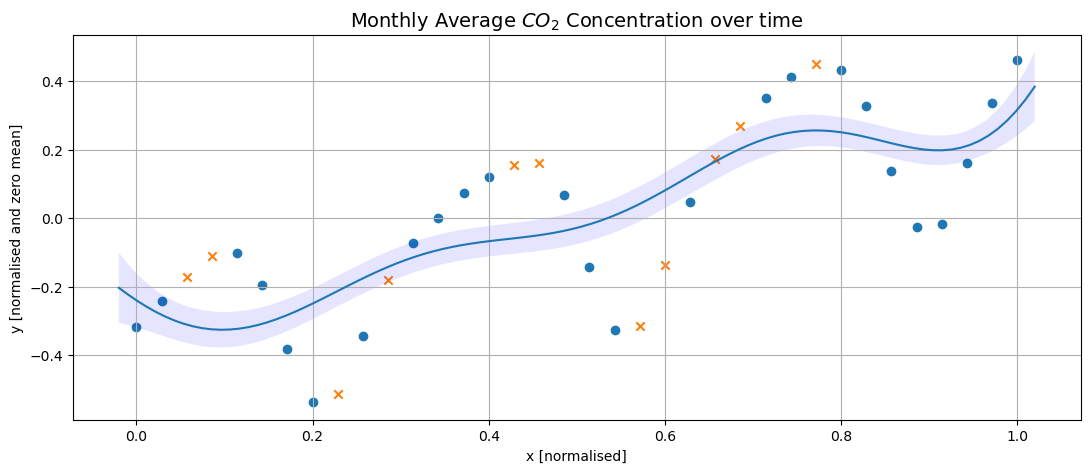

In [65]:
[f_mean_2,f_std_2] = gp.predict(x_star)
lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))

pl.figure(figsize=(13, 5))
pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.fill_between(x_star.ravel(), (f_mean_2-2*f_std_2).ravel(), (f_mean_2+2*f_std_2).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, f_mean_2)
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.grid()

In [66]:
gp.fit()

[0.3][[103.57638363]]
[0.28247324][[94.34525179]]
[0.26597045][[82.3863843]]
[0.25043178][[67.67554934]]
[0.22202484][[34.80409062]]
[0.19684015][[10.92927221]]
[0.15471697][[-2.18430516]]
[0.12160801][[-4.57242648]]
[0.07512953][[-6.20308259]]
[0.04641509][[7.61063883]]
[0.04641509][[7.61063883]]
[0.09558427][[-10.04244638]]
[0.12160801][[-4.57242648]]
[0.08474197][[-8.8091631]]
[0.10781379][[-8.23711635]]
[0.09][[-9.6938832]]
[0.10151504][[-9.5925439]]
[0.09275012][[-9.95178826]]
[0.09850503][[-9.93141257]]
[0.09415653][[-10.02025221]]
[0.09703366][[-10.01409474]]
[0.09486772][[-10.03740797]]
[0.09630624][[-10.03484078]]
[0.09522532][[-10.04147534]]
[0.09594458][[-10.04025594]]
[0.09540463][[-10.04235201]]
[0.09576426][[-10.04175034]]
[0.09549441][[-10.04249749]]
[0.09540463][[-10.04235201]]
[0.09553933][[-10.04249657]]
[0.09544951][[-10.04244926]]
[0.09551687][[-10.04250318]]
[0.09553933][[-10.04249657]]
[0.09550564][[-10.04250187]]
[0.0955281][[-10.04250142]]
[0.09551125][[-10.0425

array([0.09551603])

Optimal lengthscale: 0.0955160315204438
[[10.04250319]]


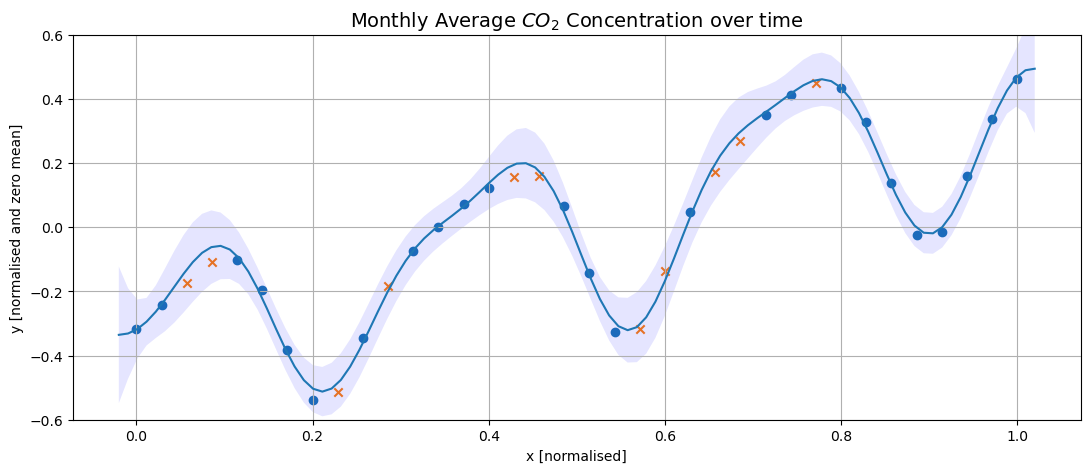

In [67]:

optimal_params = gp.optimal_params

print("Optimal lengthscale: "+str(optimal_params[0]))


#Predict for x_star
[f_mean,f_std] = gp.predict(x_star)
lml = gp.log_marginal_likelihood()
print(lml)
pl.figure(figsize=(13, 5))
pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.fill_between(x_star.ravel(), (f_mean-2*f_std).ravel(), (f_mean+2*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, f_mean)
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.ylim([-0.6,0.6])
pl.grid()

#### Warped GP Regression Implementation

The warped GP class is similar to the regular GP class, but it has the following differences:

- The target variable is warped (y_train). In this case, the warping function is a sum of hyperbolic tangents.
- The parameters of the warping functions are incorporated into the `log_marginal_likelihood` and optimized along with the GP's hyperparameters. It would look like this: 

\begin{equation}
\text{log}p(\mathbf{y}|\mathbf{X}) = -\frac{1}{2}f(\mathbf{y})^T\left(K+\sigma_n^2I\right)f(\mathbf{y}) - \frac{1}{2}\text{log}|K+\sigma_n^2I|-\frac{N}{2}\text{log}2\pi + \sum_{i=1}^Nlog(\frac{\partial{f(\mathbf{y}_n)}}{\partial{\mathbf{y}_n}})
\end{equation}

with $f$ the warping function and $N$ the number of observations.

In order to implement these two changes however, an extensive number of changes have to be implemented.

Now let us plot a regression with an arbitrary value for the hyperparameters to see that the predict function is warping properly

In [68]:
I = 1
val_a = 2
val_b = 2
val_c = 0.01
a = np.full(I, val_a)
b = np.full(I, val_b)
c = np.full(I, val_c)

nuv = 1/2
signal_variance = 1
lengthscale = 0.1
sigma_n = 0.05

gpw = GaussianProcessRegressionLengthscale("Squared Exponential", x_norm_train, y_norm_train, [signal_variance,lengthscale], sigma_n,[a,b,c], nuv)


Log Marginal Likelihood: [[-25.09294822]]


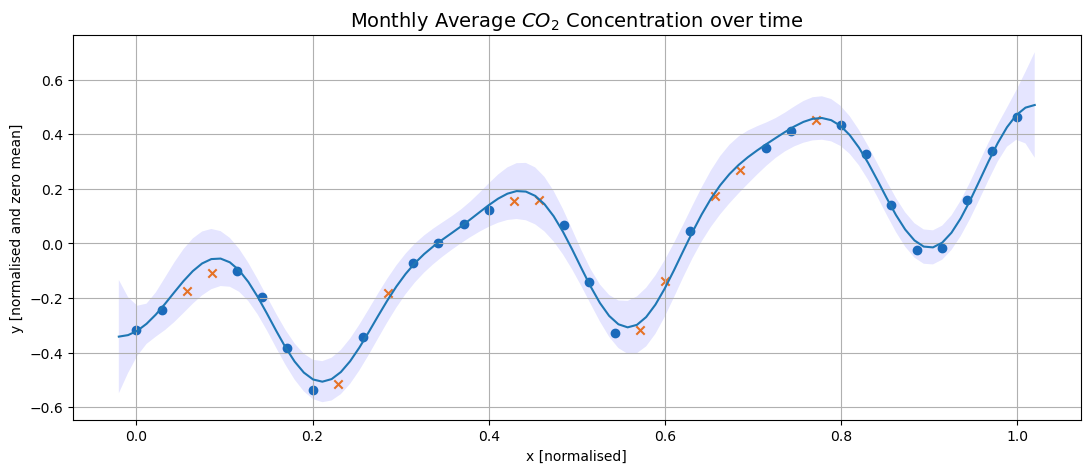

In [69]:
[fw_mean_2,fw_std_2] = gpw.predict_original(x_star)
lml = gpw.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))
fw_norm_train = 0
fw_norm_test = 0
for i in range(I):
    fw_norm_train += a[i]* np.tanh(b[i] * (y_norm_train + c[i])) 
    fw_norm_test += a[i] * np.tanh(b[i] * (y_norm_test + c[i])) 

pl.figure(figsize=(13, 5))
pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.fill_between(x_star.ravel(), (fw_mean_2-2*fw_std_2).ravel(), (fw_mean_2+2*fw_std_2).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, fw_mean_2)
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.grid()


Now optimize the hyerparameters, including the parameters of the warping function, using the `log_marginal_likelihood()` and `set_hyper_params()` functions. 

In [70]:
gpw.fit()

c:\Users\23478671\Github\Warped-GPs-\GPR.py:128: OptimizeWarning: Unknown solver options: xatol
  res = minimize(obj_func, x0, method='powell',
c:\Users\23478671\Github\Warped-GPs-\GPR.py:93: RuntimeWarning: divide by zero encountered in log
  lml4 = np.sum(np.log(self.df_dy))


[0.1  2.   2.   0.01][[25.09294822]]
[0.1  2.   2.   0.01][[25.09294822]]
[0.27182818 2.         2.         0.01      ][[1251.57996801]]
[0.01982882 2.         2.         0.01      ][[1.95123312]]
[0.04384709 2.         2.         0.01      ][[-12.77759628]]
[0.04384709 2.         2.         0.01      ][[-12.77759628]]
[0.06007686 2.         2.         0.01      ][[-19.71778884]]
[0.07298499 2.         2.         0.01      ][[-19.23657568]]
[0.06453706 2.         2.         0.01      ][[-20.26338821]]
[0.0652267 2.        2.        0.01     ][[-20.28203562]]
[0.06568406 2.         2.         0.01      ][[-20.28455645]]
[0.06596072 2.         2.         0.01      ][[-20.2822622]]
[0.06568406 2.         2.         0.01      ][[-20.28455645]]
[0.06568406 5.43656366 2.         0.01      ][[25.2690902]]
[0.06568406 0.3965763  2.         0.01      ][[9.55758956]]
[0.06568406 2.         2.         0.01      ][[-20.28455645]]
[0.06568406 1.07800618 2.         0.01      ][[-12.66836917]]
[0.065

array([6.37708463e-02, 6.88357747e+00, 5.76251168e-01, 3.37947287e-30])

Log Marginal Likelihood: [[23.96446925]]
Optimal lengthscale: 0.06377084625540295
Optimal a1:6.883577467860968
Optimal b1:0.5762511682004255
Optimal c1:3.379472868126671e-30


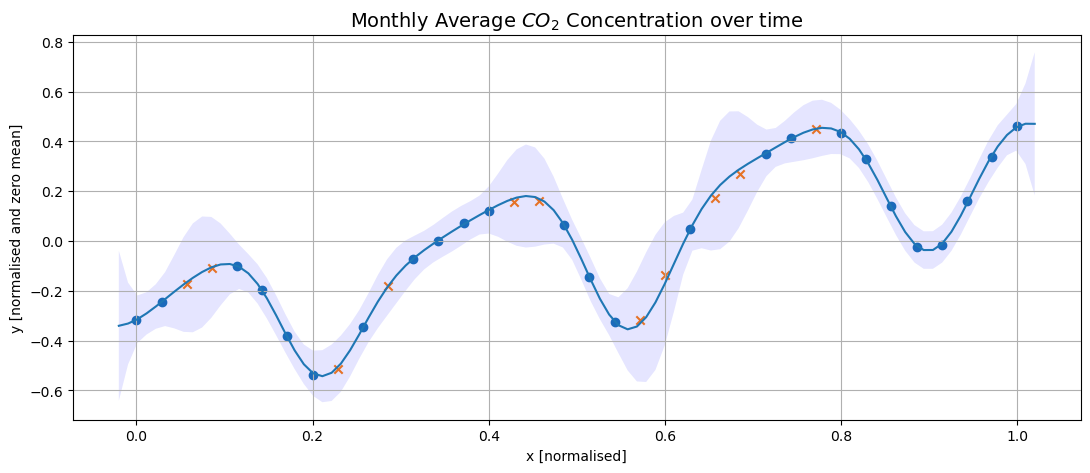

In [71]:
optimal_params = gpw.optimal_params

#Predict for x_star
[fw_mean,fw_std] = gpw.predict_original(x_star)
lml = gpw.log_marginal_likelihood()

fw_norm_train = 0
fw_norm_test = 0

print("Log Marginal Likelihood: "+str(lml))
print("Optimal lengthscale: "+str(optimal_params[0]))
for i in range(I):
    print(f'Optimal a{i+1}:' +str(optimal_params[1+3*i]))
    print(f'Optimal b{i+1}:' +str(optimal_params[2+3*i]))
    print(f'Optimal c{i+1}:' +str(optimal_params[3+3*i]))  

for i in range(I):
    fw_norm_train += optimal_params[3*i+1] * np.tanh(optimal_params[3*i+2] * (y_norm_train + optimal_params[3*i+3])) 
    fw_norm_test += optimal_params[3*i+1] * np.tanh(optimal_params[3*i+2] * (y_norm_test + optimal_params[3*i+3])) 
pl.figure(figsize=(13, 5))
pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")

pl.fill_between(x_star.ravel(), (fw_mean-2*fw_std).ravel(), (fw_mean+2*fw_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, fw_mean)
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.grid()

These are the optimal hyperparameters to fit this data with a GP. Visualize the predictions now with the optimised hyperparameters

### Compare the GP and WGP regressions

Get the predictions with the optimised hyperparameters for the GP and the WGP. In the WGP's case, we're predicting the unwarped y's with the `predict_original` function (but with the WGP-optimised hyper parameters).

In [72]:
[f_mean,f_std] = gp.predict(x_norm_test)
[fw_mean,fw_std] = gpw.predict_original(x_norm_test)

In [73]:
maewarp = np.mean(np.abs(fw_mean - y_norm_test))
mae = np.mean(np.abs(f_mean - y_norm_test))
print("GP MAE:",mae )
print("Warped GP MAE:",maewarp)

GP MAE: 0.02662972883958648
Warped GP MAE: 0.013872464264514333


In [18]:
maewarp = np.mean(np.abs((fw_mean - y_norm_test)/y_norm_test))
mae = np.mean(np.abs((f_mean - y_norm_test)/y_norm_test))
print("GP MAE:","%.1f" % (mae*100),'%' )
print("Warped GP MAE:", "%.1f" % (maewarp*100),'%')

GP MAE: 15.5 %
Warped GP MAE: 7.6 %


In [19]:
np.mean(y_norm_test)

-0.02039789301125848

In [20]:
[f_mean_warped,f_std_warped] = gpw.predict(x_norm_test)

In [74]:
[f_mean_warped,f_std_warped] = gpw.predict(x_star)
f_mean_unwarped = np.arctanh(f_mean_warped/6.88)/0.576

[[23.96446925]]


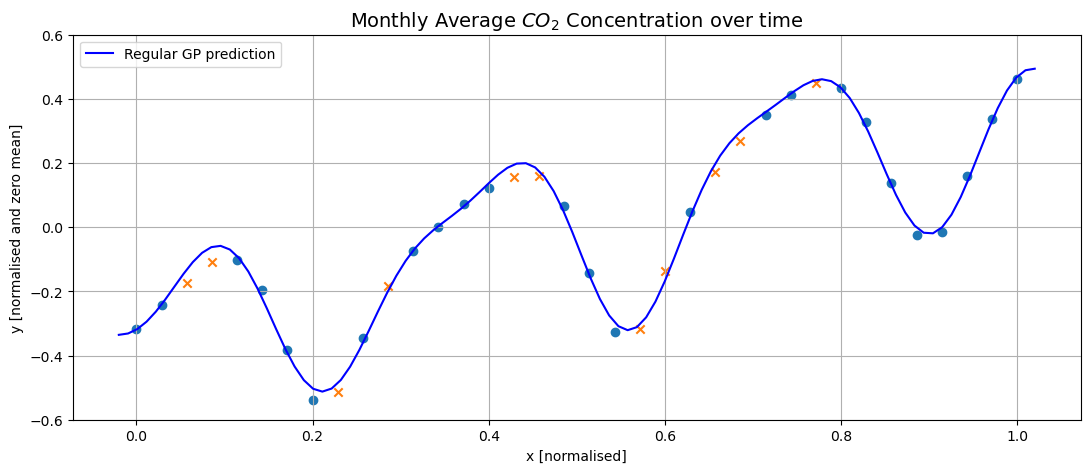

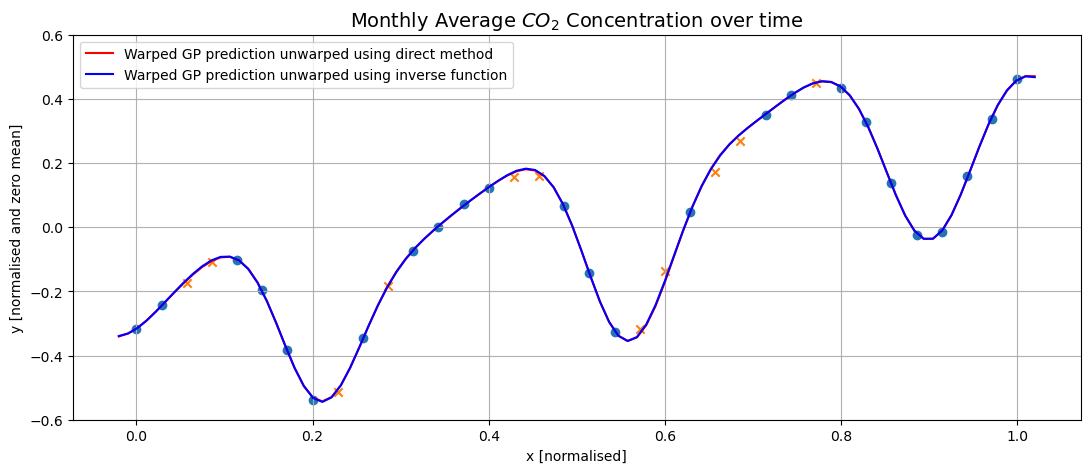

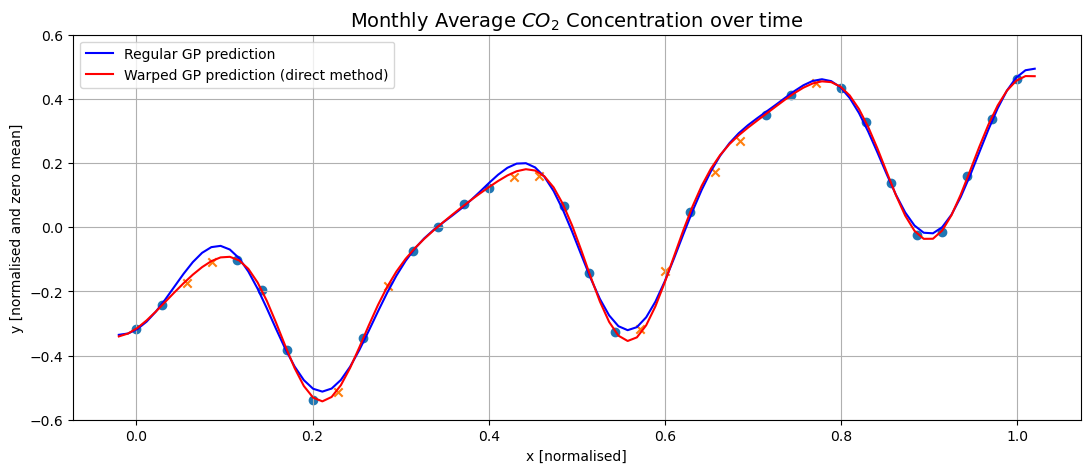

In [75]:
[f_mean,f_std] = gp.predict(x_star)
pl.figure(figsize=(13, 5))
pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
#pl.fill_between(x_star.ravel(), (f_mean-2*f_std).ravel(), (f_mean+2*f_std).ravel(), \
#                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, f_mean, 'b', label='Regular GP prediction')
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.ylim([-0.6,0.6])
pl.legend(loc='upper left')
pl.grid()


#Predict for x_star
[fuw_mean,fuw_std] = gpw.predict_original(x_star)
pl.figure(figsize=(13, 5))
pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
#pl.fill_between(x_star.ravel(), (fuw_mean-2*fuw_std).ravel(), (fuw_mean+2*fuw_std).ravel(), \
#                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, fuw_mean, 'r', label = 'Warped GP prediction unwarped using direct method')
pl.plot(x_star, f_mean_unwarped, 'b', label = 'Warped GP prediction unwarped using inverse function')
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.ylim([-0.6,0.6])
pl.legend(loc='upper left')

pl.grid()

#Predict for x_star
print(lml)
pl.figure(figsize=(13, 5))
pl.scatter(x_norm_train, y_norm_train,  label='Training points')
pl.scatter(x_norm_test, y_norm_test,marker="x",  label='Test points')
#pl.fill_between(x_star.ravel(), (f_mean-2*f_std).ravel(), (f_mean+2*f_std).ravel(), \
#                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
pl.plot(x_star, f_mean, 'b', label='Regular GP prediction')
pl.plot(x_star, fuw_mean, 'r', label = 'Warped GP prediction (direct method)')
pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
pl.ylim([-0.6,0.6])
pl.legend(loc='upper left')
pl.grid()

In [76]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.pyplot as plt

# Generate some data
X = x_norm_train
y = y_norm_train

# Define the kernel
kernel = RBF(length_scale=0.1) 
# Instantiate the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0025) 
gpr.fit(X, y)


GaussianProcessRegressor(alpha=0.0025, kernel=RBF(length_scale=0.1))

10.042503191872111 0.007038199647243275
optimal lengthscale: RBF(length_scale=0.0955)


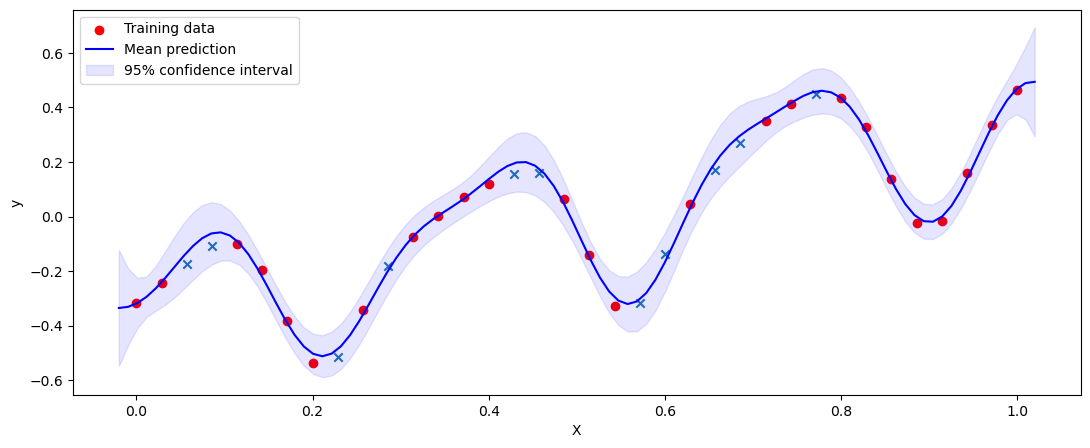

In [77]:
x_pred = x_star

# Predict the mean and standard deviation of the output for the new data
y_pred, sigma = gpr.predict(x_pred, return_std=True)

# Plot the results
print(gpr.log_marginal_likelihood_value_,np.mean(y_pred))
print('optimal lengthscale:', gpr.kernel_)
plt.figure(figsize=(13, 5))
plt.scatter(X, y, c='r', label='Training data')
plt.scatter(x_norm_test, y_norm_test,marker="x")
plt.plot(x_pred, y_pred, 'b', label='Mean prediction')
plt.fill_between(x_pred.ravel(), y_pred - 2 * sigma, y_pred + 2 * sigma, alpha=0.1, color='b', label='95% confidence interval')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()



[0.12][[-4.90860697]]
[0.10792954][[-8.20602038]]
[0.09707321][[-10.01258737]]
[0.08730888][[-9.29923363]]
[0.08730888][[-9.29923363]]
[0.09206168][[-9.90214801]]
[0.10235754][[-9.4581152]]
[0.09453424][[-10.03085511]]
[0.09206168][[-9.90214801]]
[0.09579531][[-10.04154994]]
[0.09707321][[-10.01258737]]
[0.09516269][[-10.04098557]]
[0.09643214][[-10.03219497]]
[0.09547848][[-10.042486]]
[0.09516269][[-10.04098557]]
[0.09563676][[-10.04232529]]
[0.09532045][[-10.04203757]]
[0.09555759][[-10.04248213]]
[0.09539943][[-10.04233758]]
[0.09551802][[-10.04250314]]
[0.09555759][[-10.04248213]]
[0.09549825][[-10.04249934]]
[0.0955378][[-10.04249741]]
[0.09550813][[-10.04250243]]
[0.09552791][[-10.04250147]]
[0.09551308][[-10.04250309]]
[0.09552297][[-10.04250261]]
[0.09551555][[-10.04250319]]
[0.09551308][[-10.04250309]]
[0.09551679][[-10.04250319]]
[0.09551431][[-10.04250316]]
[0.09551617][[-10.04250319]]
[0.09551679][[-10.04250319]]
[0.09551586][[-10.04250319]]
[0.09551648][[-10.04250319]]
[0

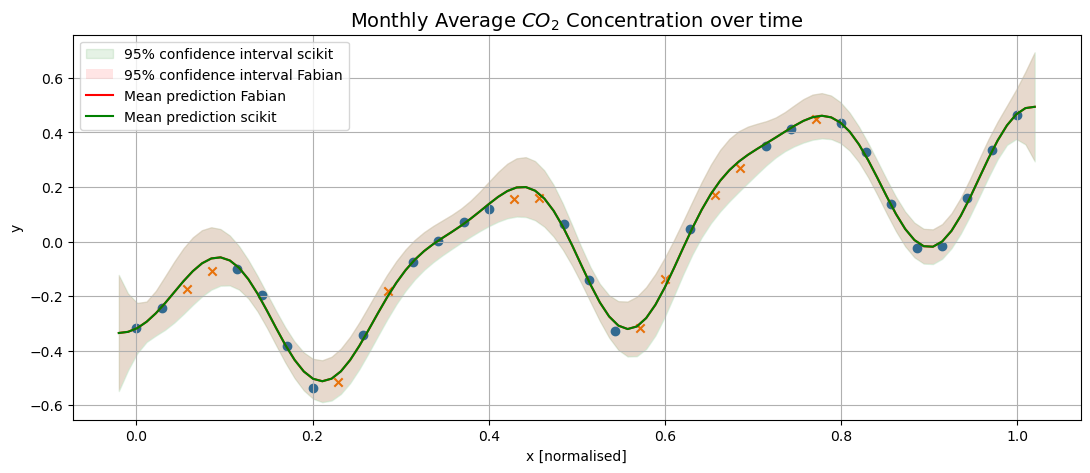

In [78]:
x_star = np.linspace(-0.02,1.02,100)[:,np.newaxis] 
signal_variance = 1 
lengthscale = 0.12
sigma_n = 0.05#0.1
gp = GaussianProcessRegressionLengthscale("Squared Exponential", x_norm_train, y_norm_train, [signal_variance,lengthscale], sigma_n)
gp.fit()

[f_mean_2,f_std_2] = gp.predict(x_star)

lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml), np.mean(f_mean_2))
plt.figure(figsize=(13, 5))
pl.scatter(x_norm_train, y_norm_train)
pl.scatter(x_norm_test, y_norm_test,marker="x")
pl.fill_between(x_pred.ravel(), (y_pred - 2 * sigma).ravel(), (y_pred + 2 * sigma).ravel(), \
                 alpha=0.1, color='g', label='95% confidence interval scikit')
pl.fill_between(x_star.ravel(), (f_mean_2-2*f_std_2).ravel(), (f_mean_2+2*f_std_2).ravel(), \
                facecolor='red', interpolate=True, alpha=0.1, label='95% confidence interval Fabian')
pl.plot(x_star, f_mean_2, 'r', label='Mean prediction Fabian')
plt.plot(x_pred, y_pred, 'g', label='Mean prediction scikit')

pl.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
pl.xlabel('x [normalised]')
pl.ylabel('y [normalised and zero mean]')
plt.ylabel('y')
plt.legend(loc='upper left')
pl.grid()